In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `~/Desktop/julia_codes/GaussianExpansionCavityMethod.jl/examples`


In [2]:
using Revise 
using Random, Graphs, GaussianExpansionCavityMethod, SparseArrays, LinearAlgebra, DifferentialEquations, DifferentialEquations.EnsembleAnalysis
import PyPlot as plt

In [3]:
N, K = 100, 3

rng = Xoshiro(1234) 

J = adjacency_matrix(random_regular_graph(N, K; rng=rng)) .* 1.2 
lambda, D, u = 0.5, 0.2, 0.02

model = Phi4Model(K, J, lambda, D, u)

x0 = rand(rng, N) 
tmax = 30.0 
tsave=collect(range(0.0, tmax; length=100))

tvec, trajs, sol = sample_phi4(model, x0, tmax, tsave; rng=rng)

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)
for i in 1:N
    ax.plot(tvec, view(trajs, i, :), color="k", alpha=0.1)
end
ax.set_xlabel("t")
ax.set_ylabel("x")

#display(fig)

PyObject Text(0, 0.5, 'x')

In [4]:
N, K = 100, 3

rng = Xoshiro(1234) 

J = adjacency_matrix(random_regular_graph(N, K; rng=rng)) .* 1.2 
lambda, D, u = 0.5, 0.2, 0.02

model = Phi4Model(K, J, lambda, D, u)

x0_min, x0_max = 1.0, 3.0
tmax = 30.0 
tsave = collect(range(0.0, tmax; length=100));

In [16]:
# Define the SDE problem
p = (model.J .- Diagonal(model.lambdas), model.u, model.D)
func = SDEFunction(GaussianExpansionCavityMethod.f!, GaussianExpansionCavityMethod.g!, jac=GaussianExpansionCavityMethod.jacobian!, ggprime=GaussianExpansionCavityMethod.milstein_derivative!, jac_prototype=deepcopy(model.J))
x0 = rand() * (x0_max - x0_min) + x0_min
sde = SDEProblem(func, x0, (0.0, tmax), p)
# Define the ensemble problem function, which changes the initial condition and the adjacency matrix at each simulation
prob_func = let p = p
    (prob, i, repeat) -> begin
    J = adjacency_matrix(random_regular_graph(N, K)) .* 1.2     
    remake(prob, u0 = rand(N) .* ((x0_max - x0_min) + x0_min), p = (J, p[2], p[3]))
    end
end
# Define the ensemble problem
ensemble_prob = EnsembleProblem(sde, prob_func=prob_func)
# Solver options
isunstable(dt,u,p,t) = any(x->x>1e6, u)
# Solve the ensemble problem
sim = solve(ensemble_prob, SOSRI(); saveat=tsave, seed=rand(rng, UInt32), unstable_check=isunstable, trajectories = 100)

EnsembleSolution Solution of length 100 with uType:
RODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, NoiseProcess{Float64, 2, Float64, Vector{Float64}, Vector{Float64}, Vector{Vector{Float64}}, typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_DIST), typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_BRIDGE), Nothing, true, ResettableStacks.ResettableStack{Tuple{Float64, Vector{Float64}, Vector{Float64}}, true}, ResettableStacks.ResettableStack{Tuple{Float64, Vector{Float64}, Vector{Float64}}, true}, RSWM{Float64}, Nothing, RandomNumbers.Xorshifts.Xoroshiro128Plus}, SDEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Tuple{SparseMatrixCSC{Float64, Int64}, Float64, Float64}, Nothing, SDEFunction{true, SciMLBase.FullSpecialize, typeof(GaussianExpansionCavityMethod.f!), typeof(GaussianExpansionCavityMethod.g!), UniformScaling{Bool}, Nothing, Nothing, typeof(GaussianExpansionCavityMethod.jacobian!), Nothing, Nothing, SparseMatrixCSC{Float64, Int64}, Sparse

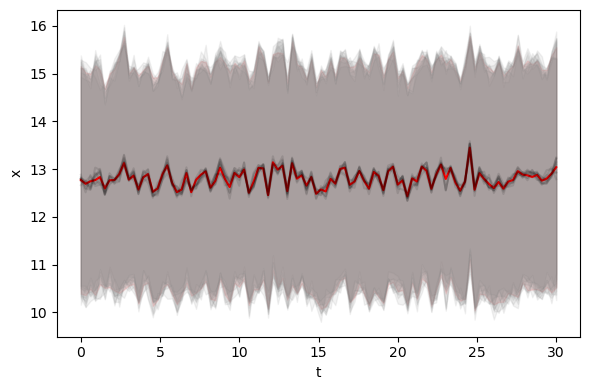

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)
mean_traj, std_traj, autocorr_traj = compute_stats(sim)
ax.plot(sim[1].t, mean_traj, color="red")
ax.fill_between(sim[1].t, mean_traj .- std_traj, mean_traj .+ std_traj, color="red", alpha=0.1)
for isim in 1:10
    mean, std, autocorr = compute_stats(sim[isim])
    ax.plot(sim[isim].t, mean, color="k", alpha=0.1)
    ax.fill_between(sim[isim].t, mean .- std, mean .+ std, color="gray", alpha=0.1)
end
ax.set_xlabel("t")
ax.set_ylabel("x")

plt.display(fig)